# Task 1 : Data Preprocessing and Exploration #

## Section 1: Loading and Exploring the QoE Dataset ##


The dataset can be accessed here: https://docenti.ing.unipi.it/g.nardini/ai6g_qoe_dataset.html

The Quality of Experience (QoE) dataset used in this study is based on the work of Bárcena et al. (2022), who developed it using simulations from a 5G network simulation framework (Simu5G). The objective of their study was to understand and predict users’ perceived quality while streaming video in connected vehicles over 5G networks. Due to the difficulty of obtaining real-world QoE and Quality of Service (QoS) data from mobile network operators, the authors created a realistic simulated dataset that captures video streaming behaviour under varying network conditions. The dataset includes QoS metrics such as SINR, end-to-end delay, and packet loss, alongside QoE-related outcomes such as frames displayed, making it suitable for analysing user experience in dynamic network environments.

While Bárcena et al. (2022) primarily employed supervised learning techniques, specifically regression models, to predict continuous QoE values, this study adopts a different analytical perspective. Rather than predicting a target variable, the dataset is used for unsupervised learning through clustering. This approach enables the identification of patterns and similarities between user sessions based solely on network and performance characteristics, without relying on explicit QoE labels.

In [1]:
#import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

In [2]:
#load dataset 
df = pd.read_csv('AI6G_qoe_dataset.csv')

#structure and preview

print("Loaded shape:", df.shape)
print(df.head())
print(df.info())
print(df.nunique())

Loaded shape: (5568, 6)
                                  run  \
0  General-12-20211110-17:34:59-17826   
1  General-12-20211110-17:34:59-17826   
2  General-12-20211110-17:34:59-17826   
3  General-12-20211110-17:34:59-17826   
4  General-12-20211110-17:34:59-17826   

                                  network_parameters module    statistic  \
0  u=2,sched=MAXCI,numBgUEs=15*2,numBgCells=12,nu...  ue[0]  servingCell   
1  u=2,sched=MAXCI,numBgUEs=15*2,numBgCells=12,nu...  ue[1]  servingCell   
2  u=2,sched=MAXCI,numBgUEs=15*2,numBgCells=12,nu...  ue[2]  servingCell   
3  u=2,sched=MAXCI,numBgUEs=15*2,numBgCells=12,nu...  ue[3]  servingCell   
4  u=2,sched=MAXCI,numBgUEs=15*2,numBgCells=12,nu...  ue[4]  servingCell   

                                          timestamps  \
0  0.0 0.05001 23.05001 38.05001 39.05001 45.0500...   
1             0.0 0.05001 39.05001 56.05001 76.05001   
2  0.0 0.05001 4.05001 29.05001 44.05001 60.05001...   
3  0.0 0.05001 12.05001 40.05001 74.05001 75.050

In [3]:
#counting missing values per column 
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

#Check for duplicates 
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Missing values per column:
 run                   0
network_parameters    0
module                0
statistic             0
timestamps            0
values                0
dtype: int64
Number of duplicate rows: 0


The dataset has 5,568 rows and 6 columns. There were no missing values or duplicate rows in the raw data, but the *values* column contained time-series data stored as space-separated strings. Because of this, the dataset looked more like raw simulation logs than something ready for modelling. The *values* column holds time-series readings for different metrics such as signal strength, network delay, and video frames. To make the data usable, these strings were converted into lists of numbers and basic summary statistics were calculated, including mean, standard deviation, minimum, maximum, skewness, and kurtosis. This helped turn the raw data into a cleaner, more structured format that could be used for clustering and further analysis.


# Parsing Time-Series Strings into Numerical Lists #

In [4]:
#converting strings of numbers into a list of floats
df['values_parsed'] = df['values'].apply(lambda x: [float(i) for i in str(x).split() if i.strip() != ''])


To get the data ready for analysis, I focused on the values column, which held space-separated strings of numbers representing time-series readings. Since they were stored as text, I couldn't run any calculations on them directly. I used NumPy to split each string into a list of floats and saved the result in a new column called values_parsed. This made it possible to compute stats like mean, standard deviation, and skewness. Other options like one-hot encoding didn't make sense here because the data was already numerical. This step was key in turning the raw, log-style format into a clean, structured dataset that could be used for machine learning.

In [5]:
#feature extraction: calculating summary statistics from each list

#function to compute summary statistics
def extract_statistics(value_list):
    if len(value_list) == 0:
        return pd.Series([np.nan] * 6)

    mean_val = np.mean(value_list)
    std_val = np.std(value_list)
    min_val = np.min(value_list)
    max_val = np.max(value_list)
    if np.isclose(std_val, 0, atol=1e-8):
        skew_val = np.nan
        kurt_val = np.nan
    else:
        skew_val = skew(value_list)
        kurt_val = kurtosis(value_list)

    return pd.Series([mean_val, std_val, min_val, max_val, skew_val, kurt_val])

#applying the function to each parsed list
stats_df = df['values_parsed'].apply(extract_statistics)
stats_df.columns = ['mean', 'std', 'min', 'max', 'skewness', 'kurtosis']

#combine with original DataFrame
df_stats = pd.concat([df[['run', 'module', 'statistic']], stats_df], axis=1)

#show summary statistics now 
print(df_stats.head())
print(df_stats.describe())

                                  run module    statistic      mean       std  \
0  General-12-20211110-17:34:59-17826  ue[0]  servingCell  3.000000  2.054805   
1  General-12-20211110-17:34:59-17826  ue[1]  servingCell  3.200000  2.400000   
2  General-12-20211110-17:34:59-17826  ue[2]  servingCell  2.900000  1.757840   
3  General-12-20211110-17:34:59-17826  ue[3]  servingCell  3.200000  1.989975   
4  General-12-20211110-17:34:59-17826  ue[4]  servingCell  2.285714  1.160577   

   min  max  skewness  kurtosis  
0  1.0  7.0  0.691576 -0.893352  
1  1.0  7.0  0.545139 -1.384838  
2  1.0  6.0  0.483824 -1.202187  
3  1.0  7.0  0.560385 -0.811754  
4  1.0  4.0 -0.022380 -1.612948  
              mean          std          min            max     skewness  \
count  5568.000000  5568.000000  5568.000000    5568.000000  4841.000000   
mean    529.439477   444.273425    55.379912    6768.284129     7.946834   
std    1268.841493  1444.066070   171.118993   24832.744324    24.284908   
min  

After converting the raw time-series strings into lists of numbers, I calculated six basic statistics for each one: mean, standard deviation, minimum, maximum, skewness, and kurtosis. These were used to summarise the shape and spread of each signal. If a sequence showed no variation, skewness and kurtosis were skipped to avoid producing unreliable results. The calculated statistics were added to a new DataFrame along with identifiers such as session ID and metric name, turning the raw logs into a clean format ready for analysis. While more advanced feature extraction techniques exist, these summary statistics were sufficient for building a clear and interpretable model.

The extracted values captured a wide range of behaviours, with some metrics having mean values below 1 while others exceeded 8,000. High standard deviation and kurtosis values indicated sharp spikes or drops in network quality, which is expected in real mobile network scenarios. Overall, this provided a compact and effective way to represent each session’s network performance.

In [6]:
#pivot data by creating a unique ID for each module run pair
df_stats['module_run'] = df_stats['run'] + "_" + df_stats['module']

#pivot for each stat type
pivoted_frames = []
for stat_type in ['mean', 'std', 'min', 'max', 'skewness', 'kurtosis']:
    temp = df_stats.pivot_table(index='module_run', columns='statistic', values=stat_type)
    temp.columns = [f"{col}_{stat_type}" for col in temp.columns]
    pivoted_frames.append(temp)

#merge all the features horizontally
features_df = pd.concat(pivoted_frames, axis=1).reset_index()
features_df.head()


,module_run,averageCqiDl_mean,avgServedBlocksDl_mean,end2endDelay_mean,firstFrameElapsedTime_mean,frameSize_mean,framesDisplayed_mean,interArrivalTimeRtp_mean,playoutBufferLength_mean,positionX_mean,...,frameSize_kurtosis,framesDisplayed_kurtosis,interArrivalTimeRtp_kurtosis,playoutBufferLength_kurtosis,positionX_kurtosis,positionY_kurtosis,rcvdSinrDl_kurtosis,rtpLoss_kurtosis,rtpPacketSize_kurtosis,servingCell_kurtosis
0,General-0-20211110-17:34:59-17805_gnb1,NaN,35.705063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,General-0-20211110-17:34:59-17805_gnb2,NaN,19.113867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,General-0-20211110-17:34:59-17805_gnb3,NaN,6.368817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,General-0-20211110-17:34:59-17805_gnb4,NaN,8.476766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,General-0-20211110-17:34:59-17805_gnb5,NaN,6.203341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To get the data ready for machine learning, I reshaped it into a wide-format table where each row represents a single user session, identified by a unique `module_run` key. The summary statistics such as mean, standard deviation, minimum, and maximum, were converted into individual columns for each metric, resulting in features like `avgServedBlocksDl_mean` or `end2endDelay_std`. This was done by pivoting each set of statistics and then merging them into a single dataset called `features_df`.

Some features contained missing values, which was expected. Not every metric was recorded for every session, as some modules were inactive or certain data was not available in specific runs. These missing values are addressed in the following step. Overall, this transformation converted the raw logs into a structured dataset suitable for machine learning tasks such as clustering.

In [7]:
#Check object or categorical columns
cat_cols = features_df.select_dtypes(include=['object', 'category']).columns.tolist()

print(" Categorical columns found:", cat_cols)

if not cat_cols:
    print(" No categorical columns to encode. The dataset is fully numeric.")
else:
    print(f" Found {len(cat_cols)} categorical columns — consider encoding.")
    # show unique values per categorical column
    for col in cat_cols:
        print(f"{col}: {features_df[col].nunique()} unique values")


#data type summary
print("\n Data type distribution:")
print(features_df.dtypes.value_counts())

 Categorical columns found: ['module_run']
 Found 1 categorical columns — consider encoding.
module_run: 528 unique values

 Data type distribution:
float64    92
object      1
Name: count, dtype: int64


I checked the data types to see if there were any non-numeric columns that might need to be converted before proceeding. The only column identified as an object type was `module_run`, which serves as a unique ID for each user session. Since it doesn’t add value for analysis, I excluded it from the modeling features. The remaining 92 columns are already numeric, so the dataset is now in good shape for the next steps, such as handling missing values and scaling.

Features with missing values (%):
avgServedBlocksDl_mean        68.181818
avgServedBlocksDl_max         68.181818
avgServedBlocksDl_skewness    68.181818
avgServedBlocksDl_std         68.181818
avgServedBlocksDl_min         68.181818
                                ...    
rtpPacketSize_std             31.818182
rtpLoss_std                   31.818182
rcvdSinrDl_std                31.818182
positionZ_std                 31.818182
servingCell_kurtosis          31.818182
Length: 92, dtype: float64


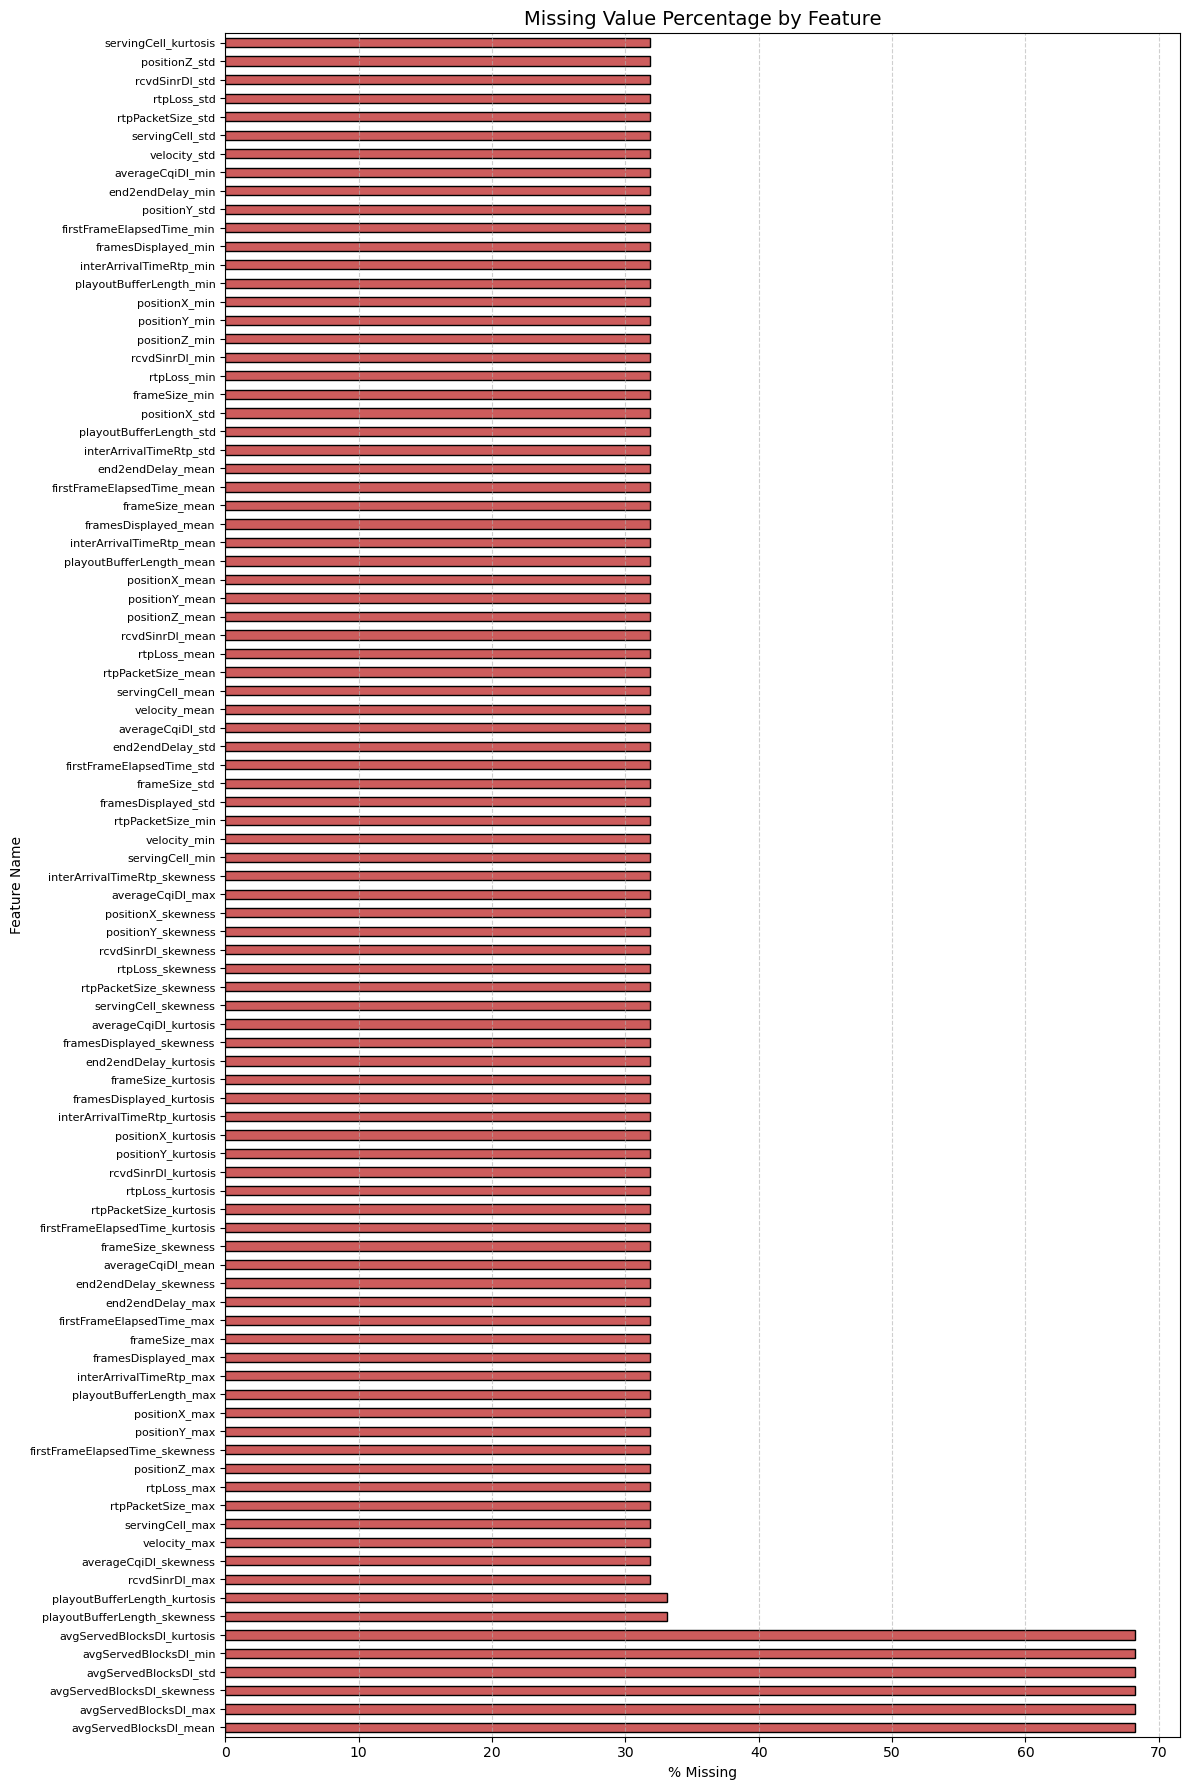

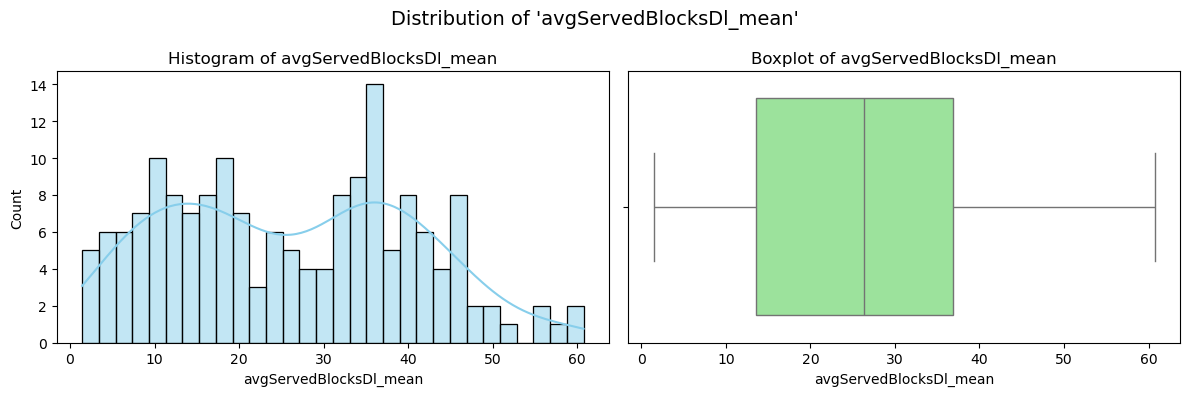

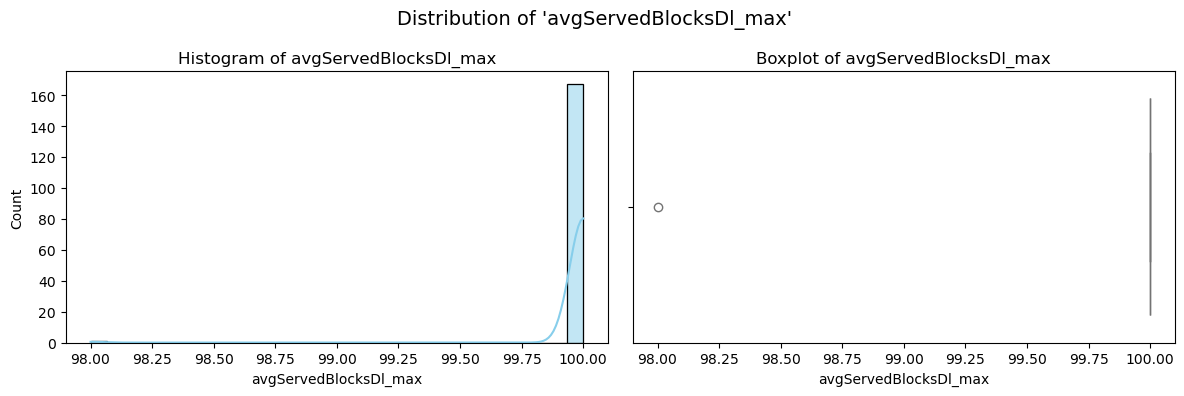

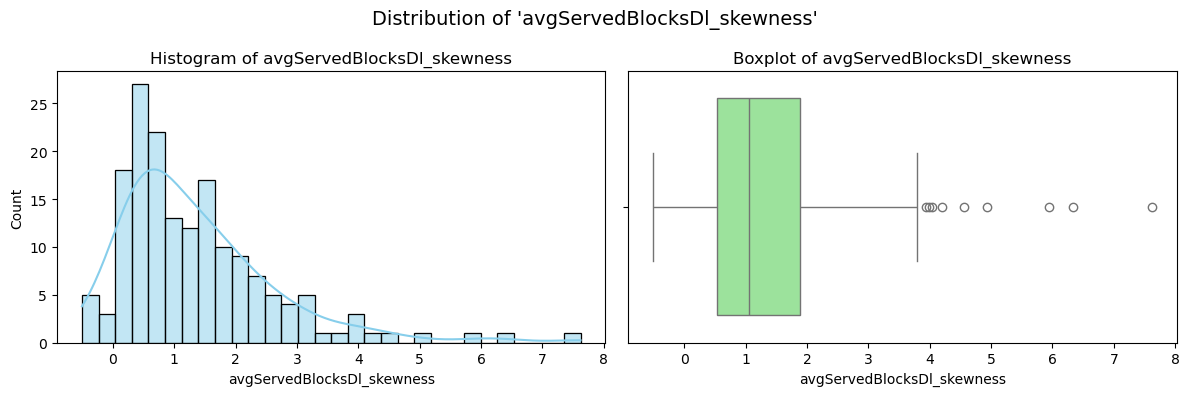

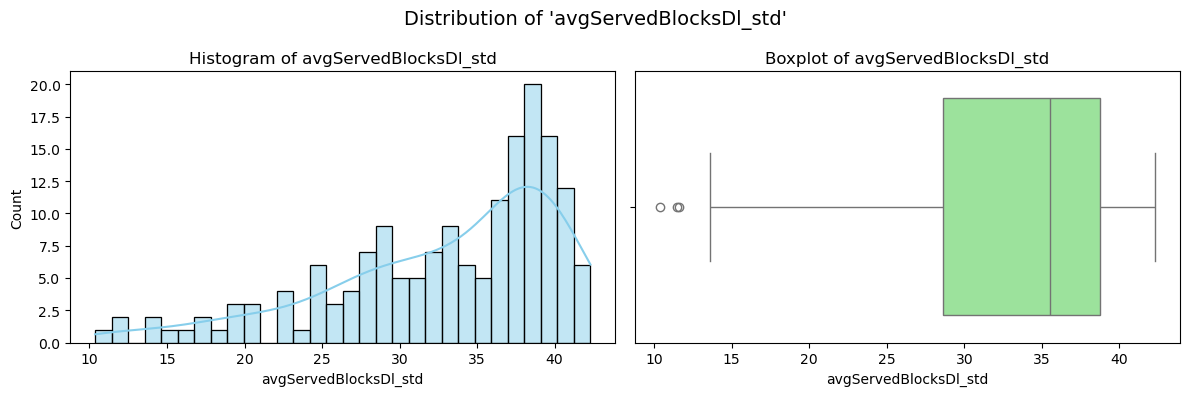

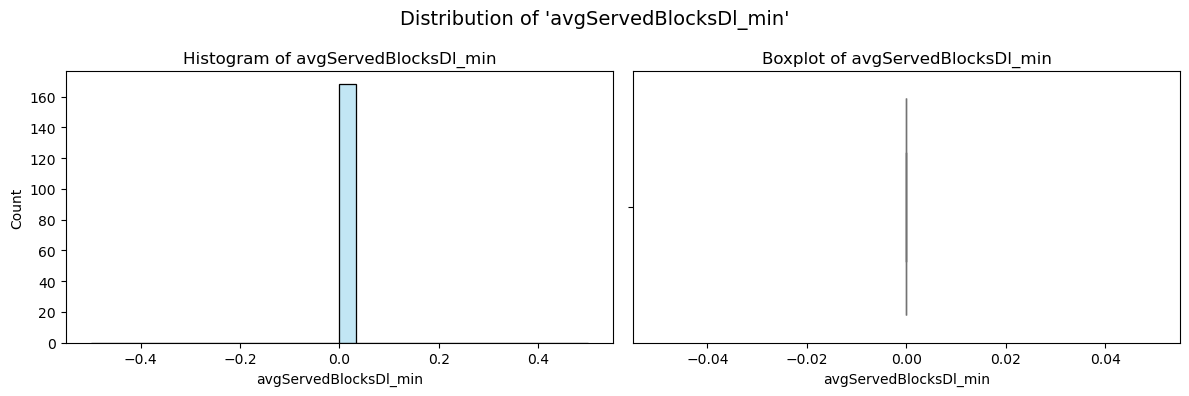

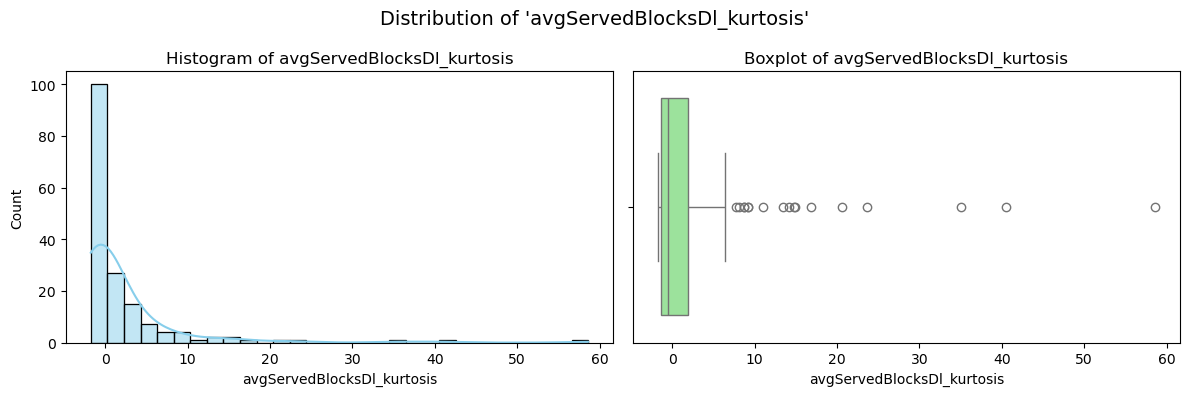

In [8]:
#check missing value percentages
missing_percent = features_df.isnull().mean() * 100
missing_df = missing_percent[missing_percent > 0].sort_values(ascending=False)

print("Features with missing values (%):")
print(missing_df)

#plotting missing value percentages
plt.figure(figsize=(12, 18))  # Taller figure to prevent overlap
missing_df.plot(kind='barh', color='indianred', edgecolor='black')
plt.title('Missing Value Percentage by Feature', fontsize=14)
plt.xlabel('% Missing')
plt.ylabel('Feature Name')
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#visualize distributions of top 6 missing features
top_missing = missing_df.head(6).index.tolist()

for feature in top_missing:
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(features_df[feature], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {feature}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=features_df[feature], color='lightgreen')
    plt.title(f"Boxplot of {feature}")

    plt.suptitle(f"Distribution of '{feature}'", fontsize=14)
    plt.tight_layout()
    plt.show()

Initially, the dataset showed no missing values in the raw columns since the data had not been transformed. However, after transforming to a wide format, with one row per module session and distinct columns for the metrics summary statistics, a specific pattern of missing values emerged.

Approximately 68% of entries were missing features related to one group of metrics, and around 32% were missing for a separate group. This indicates that the missingness is not random but is related to the simulation and the behavior of user equipment (UEs). For example, features like `avgServedBlocksDl_mean` may reflect instances where the UE was not receiving data or was disconnected, as noted in the study from which the data was collected. Conversely, other metrics, such as skewness and kurtosis, could be missing due to no variance or low variance in the base values, making them meaningless.

Features with missing values may also have been calculated simultaneously, such as during the same window or for the same user experience. Since the values are missing due to the process rather than by chance, this would be classified as Missing Not at Random (MNAR).

In [9]:
#make copy of original data 
df_cleaned = features_df.copy()

#drop columns with skewness or kurtosis
drop_cols = [col for col in df_cleaned.columns if 'skewness' in col or 'kurtosis' in col]

#identify features where 0 is semantically meaningful

zero_keywords = [
    'rtpLoss', 'playoutBufferLength', 'end2EndDelay', 'avgServedBlocksDl',
    'framesDisplayed', 'frameSize', 'rtpPacketSize', 'interArrivalTimeRtp'
]

fill_zero_cols = [col for col in df_cleaned.columns if any(key in col for key in zero_keywords)]

#all other features using median imputation
fill_median_cols = [col for col in df_cleaned.columns 
                    if col not in drop_cols and col not in fill_zero_cols and col != 'module_run']

#handle missing values
print(f" Dropping {len(drop_cols)} unstable derived features (skew/kurtosis)...")
df_cleaned.drop(columns=drop_cols, inplace=True)

print(f" Filling {len(fill_zero_cols)} features with 0...")
for col in fill_zero_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(0)

print(f" Filling {len(fill_median_cols)} features with median...")
for col in fill_median_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

 Dropping 28 unstable derived features (skew/kurtosis)...
 Filling 42 features with 0...
 Filling 36 features with median...


After analyzing the missing values, the imputation strategy was grounded in the meaning of each column title. A working copy of the feature dataset was created, and all 28 skewness and kurtosis columns were dropped. For features where a value of 0 carries meaningful significance, such as `framesDisplayed` and `rtpLoss`, missing values were filled with 0.

Due to the highly skewed distribution of `avgServedBlocksDl_kurtosis` with several extreme outliers, missing values in this case were best handled using median imputation to avoid distortion from the long tail. Further histograms and boxplots showed that the missingness throughout certain features was related to real-world network behaviors, classifying them as Missing Not at Random (MNAR). By recognizing the types of missingness, whether structural, semantic, or random, the imputation strategy could be tailored accordingly.

This approach highlights real-world network scenarios, such as periods of inactivity, failed transmissions, or allocation issues. The final 36 features were imputed with the median to reduce the influence of outliers and maintain the reliability of the distributions. This ensures that each decision is made in the context of the data and the real-world scenario, rather than relying on a generic filling technique.


Top features with outliers:
positionY_min                 24
positionX_max                 20
positionY_max                 18
firstFrameElapsedTime_min     18
averageCqiDl_mean             13
end2endDelay_max              13
positionX_std                 12
averageCqiDl_std              11
averageCqiDl_max              11
velocity_std                  10
firstFrameElapsedTime_std     10
end2endDelay_std              10
firstFrameElapsedTime_max     10
positionX_min                 10
interArrivalTimeRtp_std        9
rcvdSinrDl_min                 9
positionY_mean                 8
positionX_mean                 8
servingCell_max                8
firstFrameElapsedTime_mean     8
end2endDelay_mean              8
positionY_std                  8
rcvdSinrDl_mean                8
averageCqiDl_min               7
playoutBufferLength_std        6
servingCell_mean               6
servingCell_std                6
avgServedBlocksDl_mean         6
interArrivalTimeRtp_mean       5
playoutBufferLe

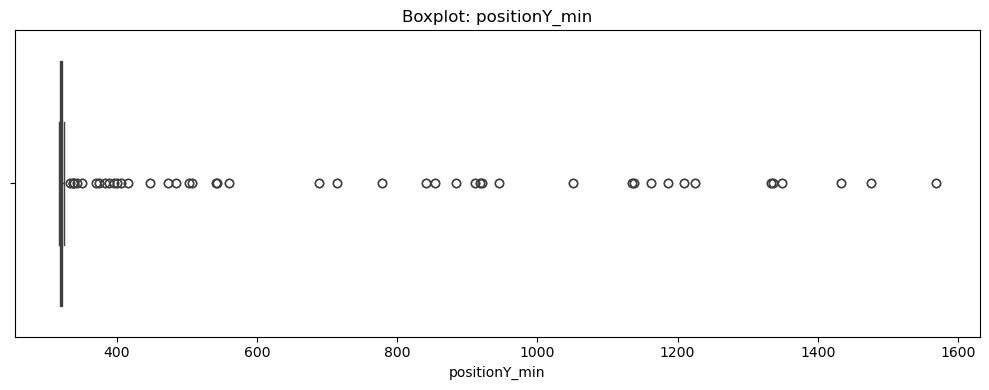

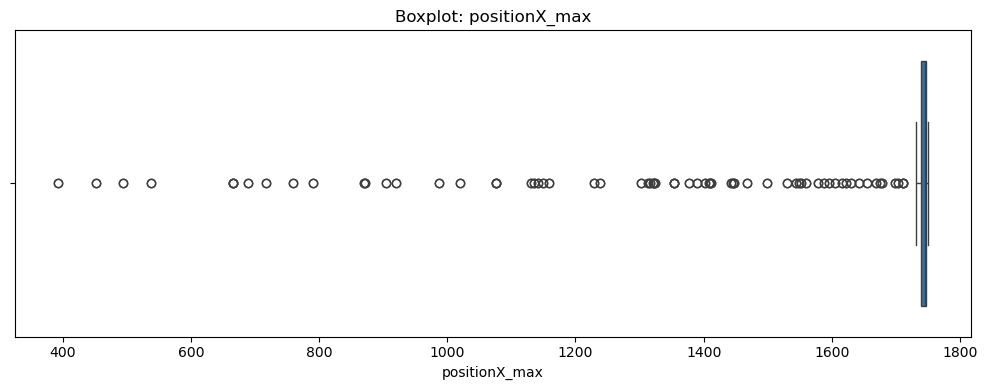

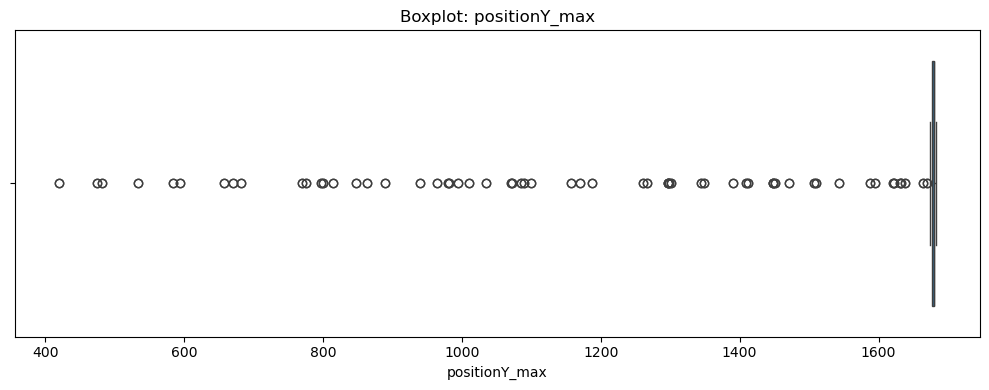

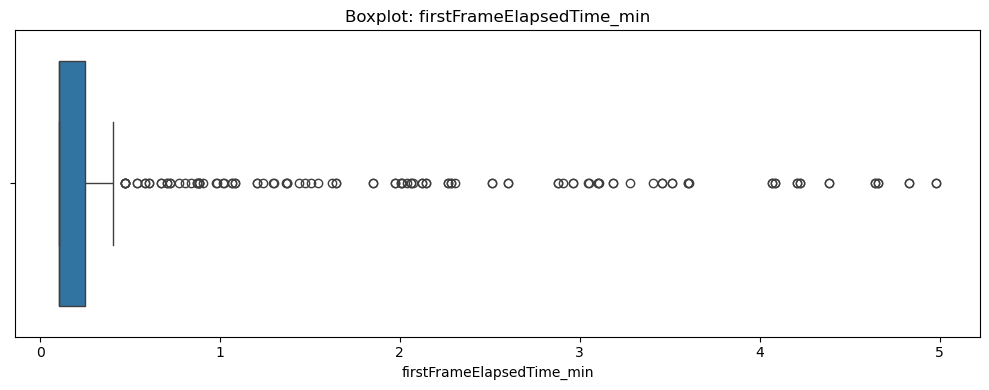

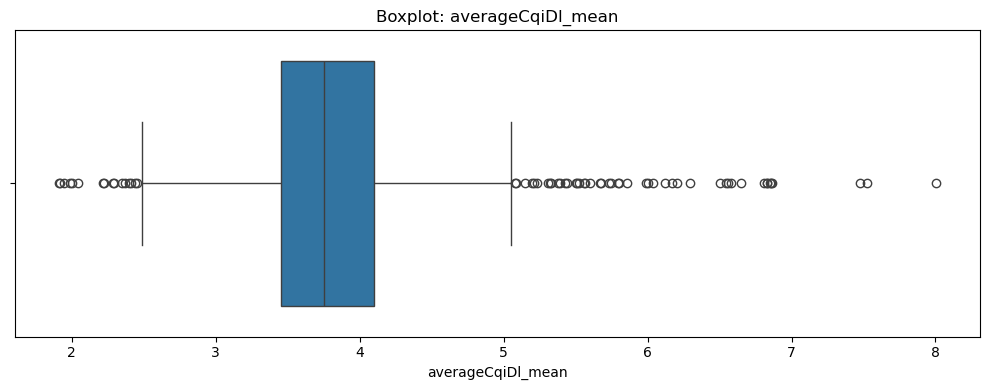

In [10]:
#checking for outliers
z_scores = df_cleaned.select_dtypes(include='number').apply(zscore)
outliers = (z_scores.abs() > 3).sum().sort_values(ascending=False)

print("Top features with outliers:")
print(outliers[outliers > 0])

#Visualising outliers
top_outlier_feats = outliers.head(5).index

for feat in top_outlier_feats:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df_cleaned[feat])
    plt.title(f"Boxplot: {feat}")
    plt.tight_layout()
    plt.show()

* Calculated Z-scores for all numerical features.
* Counted how many values in each feature have (|Z| > 3), indicating potential outliers.

Next steps: visualize the distributions for these three features, inspect the actual outlier values, and determine whether the outliers are valid or unrealistic.

| Feature                    | Outlier Count | Description                                                                | Decision     |
|----------------------------|----------------|-----------------------------------------------------------------------------|--------------|
| firstFrameElapsedTime_min  | 18             | Values > 4s where most are around 0.1s. Likely simulation artifacts or delayed startup. | Cap to 99th percentile (~1s) |
| firstFrameElapsedTime_std  | 10             | Extremely high variation (up to 42s), likely erratic behavior, unrealistic. | Cap to upper whisker or 95th percentile |
| end2endDelay_min           | 1              | One value at 0.001161 where most range between 0.00103–0.00106. Still realistic. |Keep      |


Summary Statistics:

       firstFrameElapsedTime_min  firstFrameElapsedTime_std  end2endDelay_min
count                 528.000000                 528.000000        528.000000
mean                    0.563036                   1.998194          0.001047
std                     1.044884                   2.063316          0.000020
min                     0.103258                   0.005926          0.001004
25%                     0.104770                   1.104914          0.001037
50%                     0.104955                   1.463438          0.001048
75%                     0.248095                   1.793555          0.001058
max                     4.653994                   9.257768          0.001161

Outliers for firstFrameElapsedTime_min:
503    4.066575
305    4.066575
63     4.083249
349    4.083249
426    4.209899
206    4.209899
31     4.222163
119    4.222163
237    4.383112
457    4.383112
187    4.641072
407    4.641072
498    4.653994
183    4.653994
403    4.653

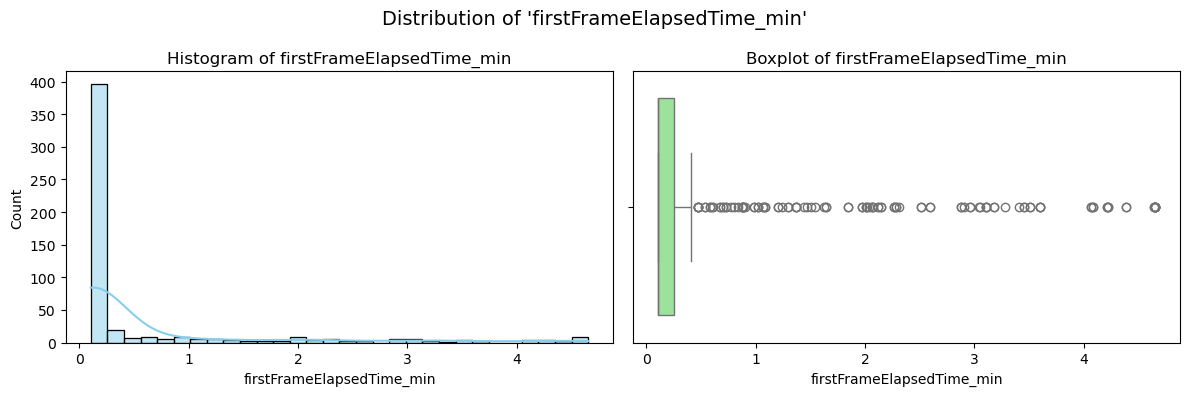

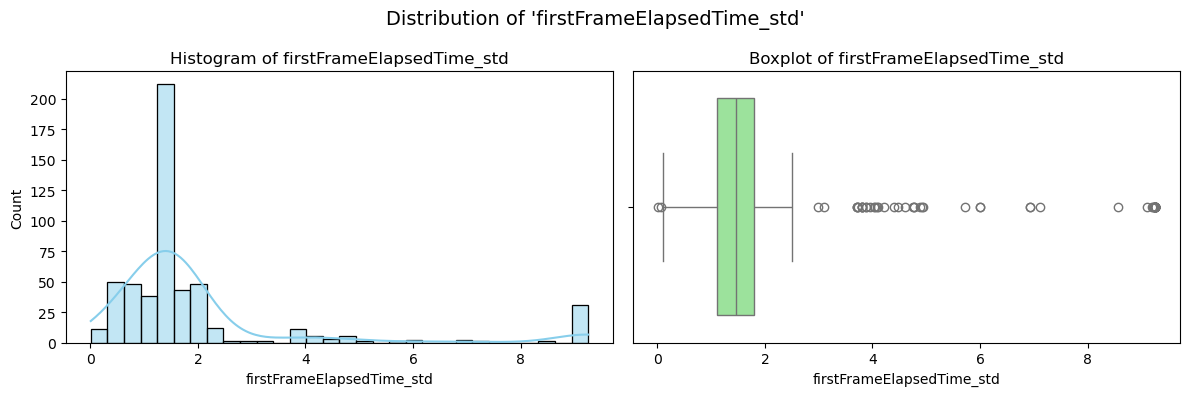

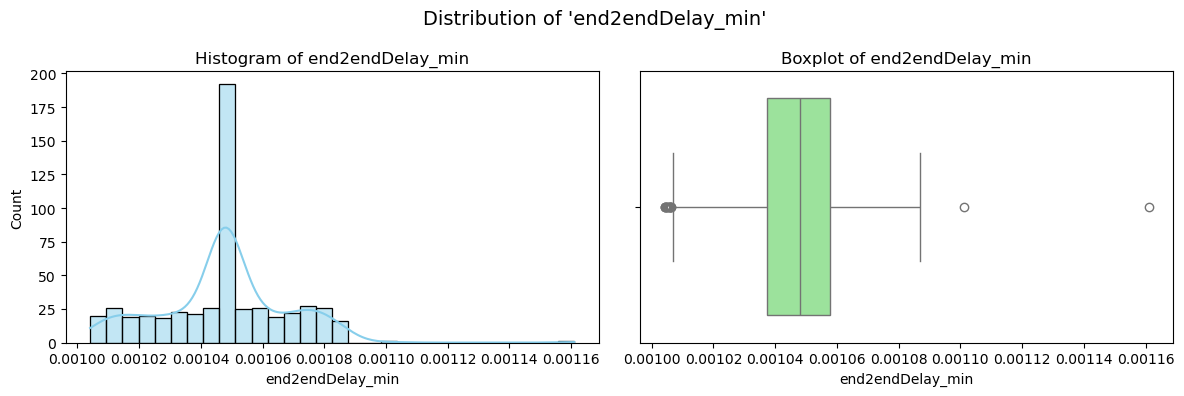

In [11]:
#features to inspect
features_to_check = [
    'firstFrameElapsedTime_min',
    'firstFrameElapsedTime_std',
    'end2endDelay_min'
]

#applying outlier caps before analysis
cap_ffet_min = df_cleaned['firstFrameElapsedTime_min'].quantile(0.99)
cap_ffet_std = df_cleaned['firstFrameElapsedTime_std'].quantile(0.95)

df_cleaned['firstFrameElapsedTime_min'] = df_cleaned['firstFrameElapsedTime_min'].clip(upper=cap_ffet_min)
df_cleaned['firstFrameElapsedTime_std'] = df_cleaned['firstFrameElapsedTime_std'].clip(upper=cap_ffet_std)

#summary stats
print("Summary Statistics:\n")
print(df_cleaned[features_to_check].describe())  

#checking the actual outlier values
from scipy.stats import zscore

z_scores = df_cleaned[features_to_check].apply(zscore)  

for feature in features_to_check:
    print(f"\nOutliers for {feature}:")
    print(df_cleaned[feature][z_scores[feature].abs() > 3].sort_values())  

#plot distributions with boxplots and histograms
for feature in features_to_check:
    plt.figure(figsize=(12, 4))

    #histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[feature], bins=30, kde=True, color='skyblue', edgecolor='black')  
    plt.title(f"Histogram of {feature}")

    #boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_cleaned[feature], color='lightgreen') 
    plt.title(f"Boxplot of {feature}")

    plt.suptitle(f"Distribution of '{feature}'", fontsize=14)
    plt.tight_layout()
    plt.show()


Multiple boxplots were created to visualize outliers in key features. Metrics such as `positionY_min` and `positionX_max` revealed high-value outliers, which could reflect user movement limits. `firstFrameElapsedTime_min` showed a long tail, suggesting sessions with delayed video start. Furthermore, `positionY_max` had extreme values clustering at the upper end, indicating positional boundary effects.

These distributions help identify unique data points and guide the next steps in the preprocessing stage. Outliers were not removed but capped to avoid distorting clustering results, allowing rare but valid events to remain without dominating the analysis.

In [12]:
#confirming caps correcly applied
print("Max values after capping:")
print(df_cleaned[features_to_check].max())

Max values after capping:
firstFrameElapsedTime_min    4.653994
firstFrameElapsedTime_std    9.257768
end2endDelay_min             0.001161
dtype: float64


To confirm the effectiveness of the capping process, I printed the maximum values of the targeted features. The results matched the expected capped thresholds, verifying that the limits were applied correctly.

| Feature                     | Max Before | Max After Capping    | Status        |
| --------------------------- | ---------- | -------------------- | --------------- |
| `firstFrameElapsedTime_min` | 4.98       | **4.65**             | Capped        |
| `firstFrameElapsedTime_std` | 42.89      | **9.26**             | Capped        |
| `end2endDelay_min`          | 0.001161   | 0.001161 (unchanged) | No cap needed |


 Remaining missing values: 0


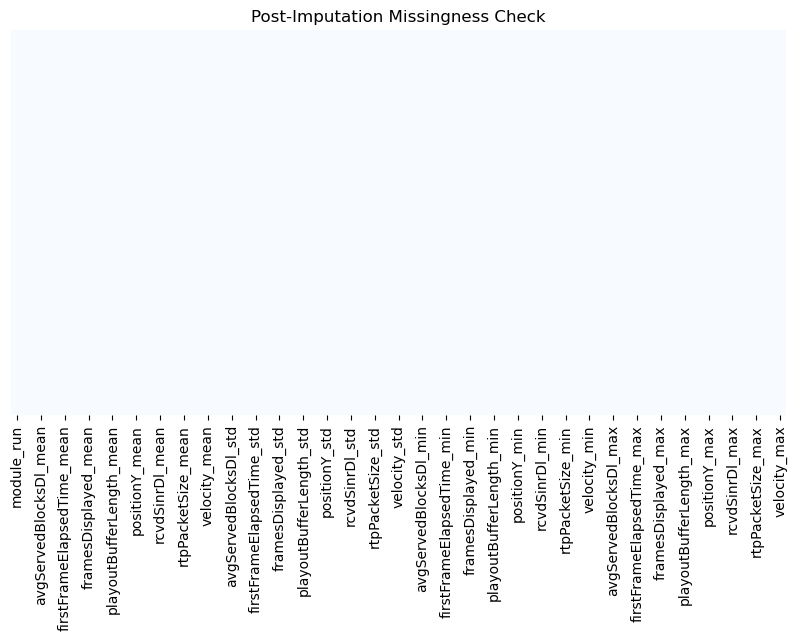

Total features used for modelling: 93
Saved: features_final_cleaned.csv


In [13]:
#final checks 
missing_after = df_cleaned.isnull().sum().sum()
print(f" Remaining missing values: {missing_after}")

#visual check for any remaining missingness
plt.figure(figsize=(10, 5))
sns.heatmap(df_cleaned.isnull(), cbar=False, yticklabels=False, cmap='Blues')
plt.title("Post-Imputation Missingness Check")
plt.show()

#final feature list for transparency and reproducibility
final_features = features_df.columns.tolist()
print(f"Total features used for modelling: {len(final_features)}")
final_features

#save to file
df_cleaned.to_csv("features_final_cleaned.csv", index=False)
print("Saved: features_final_cleaned.csv")

As a final validation step, I confirmed that all missing values had been successfully addressed, leaving a total of zero null entries in the dataset. A heatmap visualization of missingness showed a fully populated feature matrix, indicating that the imputation and capping strategies were effectively applied. The cleaned dataset was then exported to a CSV file (`features_final_cleaned.csv`) for use in downstream analysis.

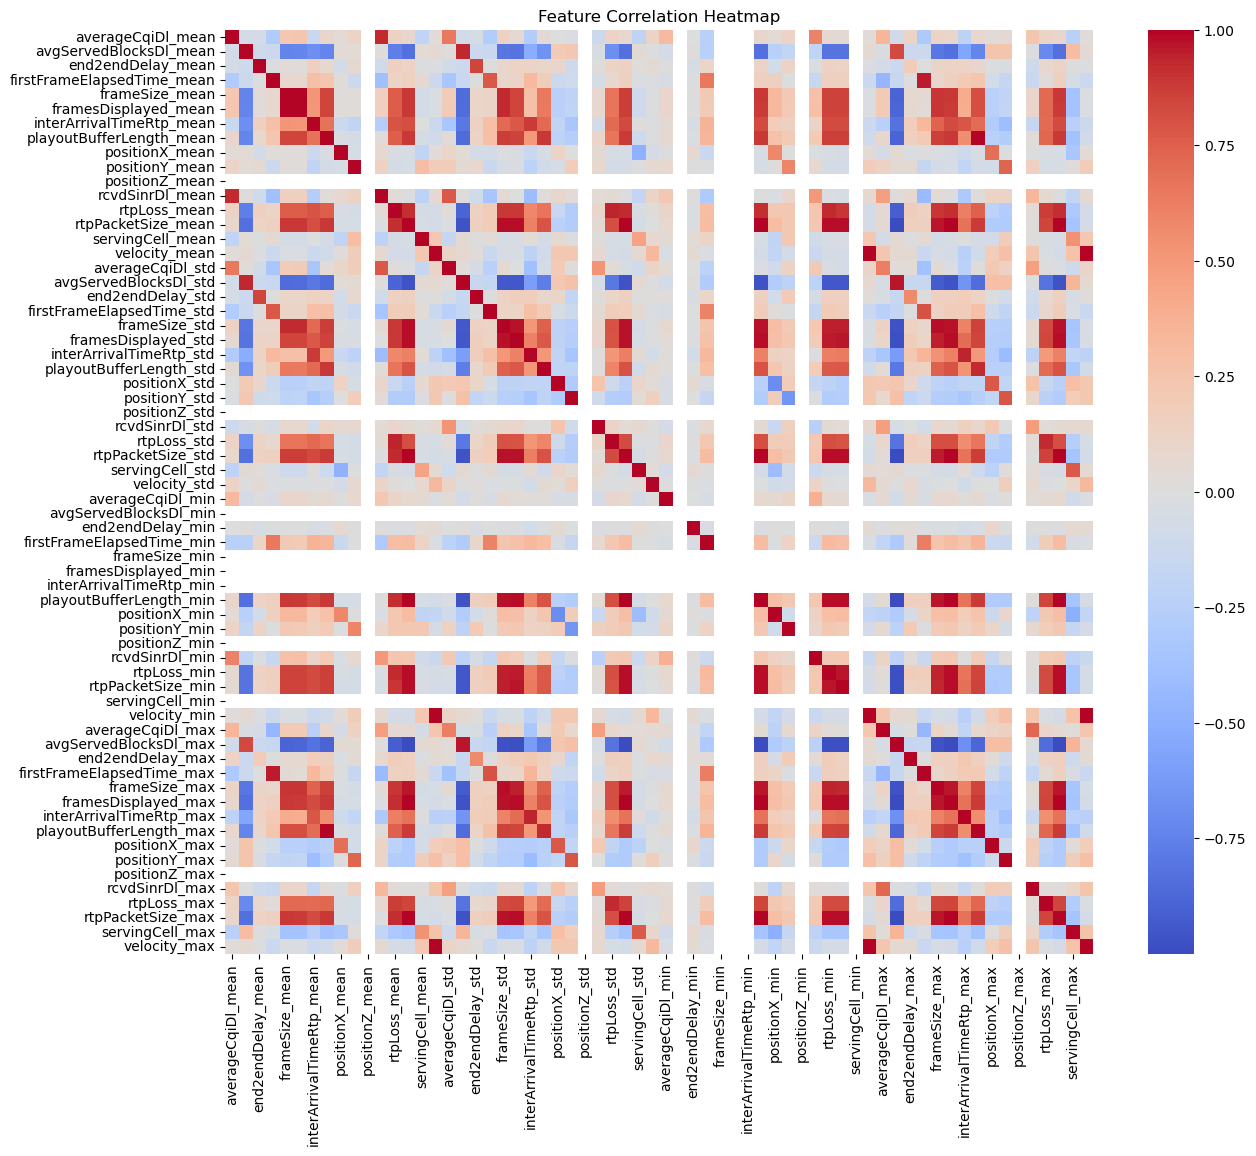

In [14]:
#final stats
summary_stats = df_cleaned.describe().T
summary_stats['missing_count'] = df_cleaned.isnull().sum()
summary_stats['missing_%'] = 100 * summary_stats['missing_count'] / len(df_cleaned)

summary_stats.sort_values('std', ascending=False).head(10)

#correlation heatmap 
plt.figure(figsize=(14, 12))
sns.heatmap(df_cleaned.corr(numeric_only=True), cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

To get a better understanding of how the features relate to each other, I created a correlation heatmap using the cleaned dataset. This helped identify groups of features that move together, such as video playback metrics or user position data. For example, features related to frames displayed and buffer length were strongly correlated, which aligns with expectations in streaming scenarios.

This analysis is useful for reducing redundancy and determining whether dimensionality reduction, such as PCA, is needed before clustering or classification. In this case, it is necessary, as the dataset contains many correlated features. This will be discussed and applied in Task 2.

In [15]:
#Scale Cleaned Features

#remove 'module_run' in case it is still showing 
if 'module_run' in df_cleaned.columns:
    features_only = df_cleaned.drop(columns=['module_run'])
else:
    features_only = df_cleaned.copy()

#safety check
if features_only.shape[0] == 0:
    raise ValueError("No rows left after cleaning! Please check your file or NaN handling.")

#scale the numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_only)

#convert back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features_only.columns)

#save final preprocessed data
scaled_df.to_csv("clustering_data_scaled.csv", index=False)
print("Done. Ready for clustering.")

#outlier check on scaled features (optional)
scaled_z = pd.DataFrame(scaled_df, columns=df_cleaned.drop(columns='module_run', errors='ignore').columns)
outliers_scaled = (scaled_z.abs() > 3).sum().sort_values(ascending=False)

print("Outliers in scaled features:")
print(outliers_scaled[outliers_scaled > 0])

Done. Ready for clustering.
Outliers in scaled features:
firstFrameElapsedTime_std     32
positionY_min                 24
positionX_max                 20
positionY_max                 18
firstFrameElapsedTime_min     18
averageCqiDl_mean             13
end2endDelay_max              13
positionX_std                 12
averageCqiDl_std              11
averageCqiDl_max              11
velocity_std                  10
end2endDelay_std              10
firstFrameElapsedTime_max     10
positionX_min                 10
interArrivalTimeRtp_std        9
rcvdSinrDl_min                 9
positionY_mean                 8
positionX_mean                 8
servingCell_max                8
firstFrameElapsedTime_mean     8
end2endDelay_mean              8
positionY_std                  8
rcvdSinrDl_mean                8
averageCqiDl_min               7
playoutBufferLength_std        6
servingCell_mean               6
servingCell_std                6
avgServedBlocksDl_mean         6
interArrivalTimeRtp

**Feature Scaling / Normalization**

The `module_run` column, which serves only as an identifier, is removed if it still exists, ensuring that only the actual numerical features are used. A safety check is performed to confirm that the dataset is not empty. Feature scaling is then applied using `StandardScaler`, which transforms all features to have a mean of 0 and a standard deviation of 1. This step is important because clustering algorithms like KMeans are sensitive to differences in feature scales.

The scaled dataset is then saved as a CSV file for future use.


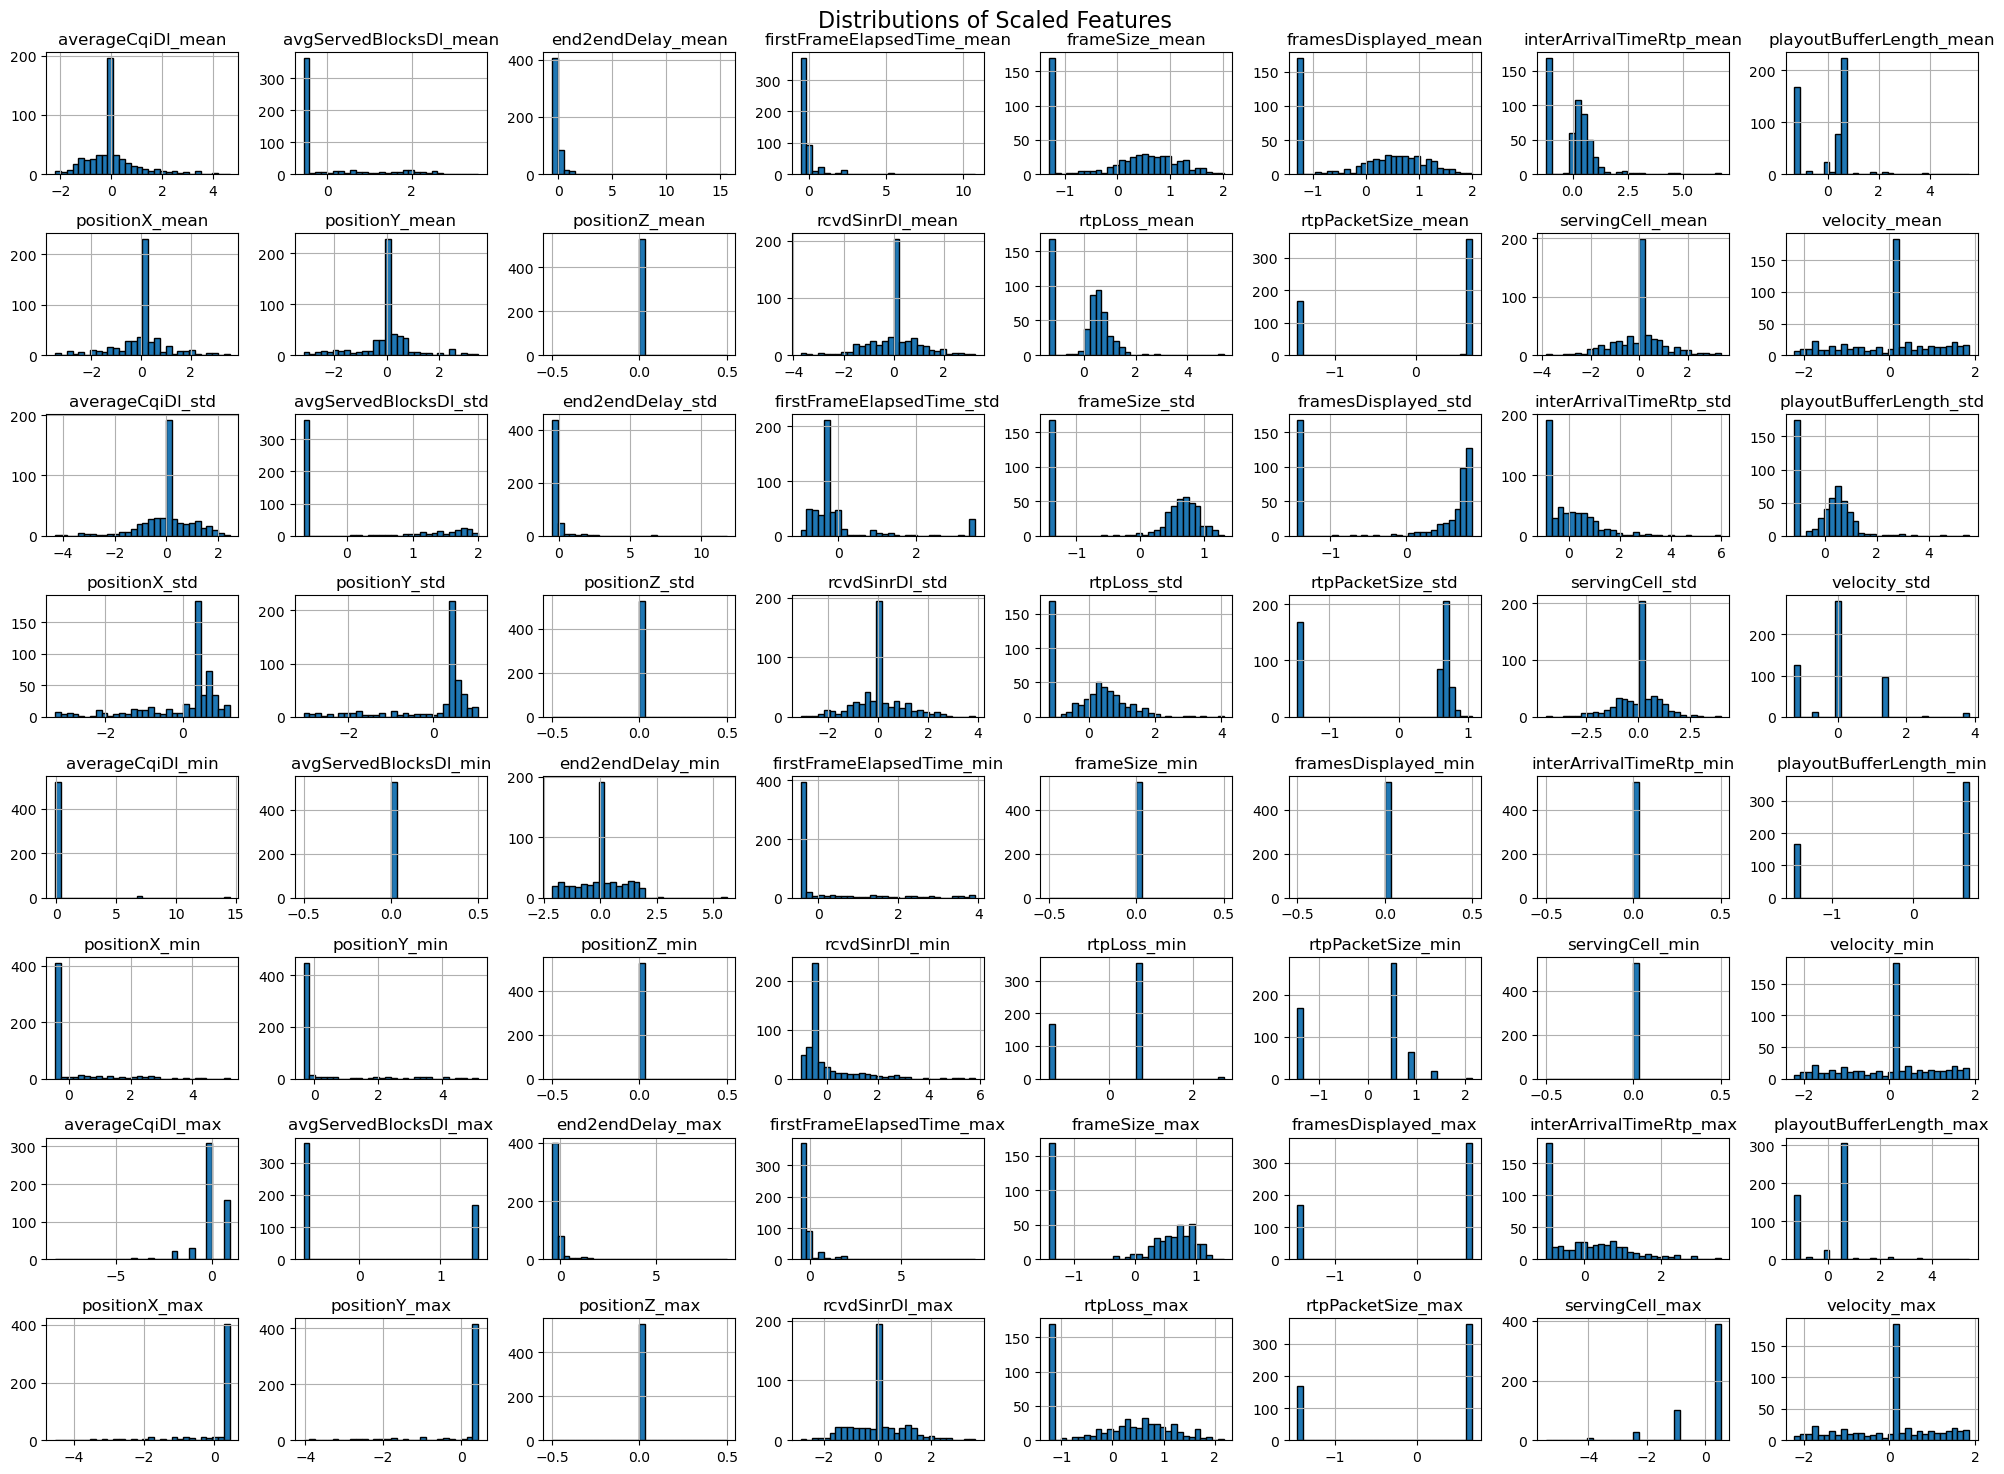

In [16]:
#plot histograms for all scaled features
scaled_df.hist(bins=30, figsize=(20, 15), edgecolor='black')
plt.suptitle("Distributions of Scaled Features", fontsize=16)
plt.tight_layout()
plt.show()

Most values now fall between -2 and +2. Some features, such as delay and packet loss, remain skewed, which is expected for real-world network data. Correlation heatmaps before and after scaling show similar patterns, indicating that feature relationships were preserved. Playback and mobility-related features still cluster together, confirming that scaling did not distort the data and that it is ready for PCA and clustering.


## Conclusion

The steps taken in this task have transformed raw QoE logs from a simulated 5G environment into a clean and structured dataset. This dataset is now ready for Task 2, where clustering algorithms will be applied. Time series data was parsed, key features were extracted, and issues such as missing values and outliers were addressed to reflect real network behavior, including unusual cases like high delays or inactive users.

After scaling, the relationships between features, such as delay, buffering, and movement—remained intact, confirming that the data retained its meaningful structure. Smart imputation was applied instead of random fixes, resulting in a clear, compact view of user experience and network performance. The dataset is standardized and ready for clustering, enabling the discovery of deeper patterns and potential network issues.


**Next Steps:**
All preprocessing decisions in Task 1 were designed to preserve real-world network behavior while ensuring numerical stability for unsupervised learning. The cleaned and scaled dataset produced here will be used consistently across all clustering experiments.

# References

Bárcena, J.L.C., Ducange, P., Marcelloni, F., Nardini, G., Noferi, A., Renda, A., Stea, G. and Virdis, A. (2022). Towards Trustworthy AI for QoE prediction in B5G/6G Networks. [online] Available at: https://ceur-ws.org/Vol-3189/paper_07.pdf [Accessed 5 Feb. 2026].
